In [24]:
from statistics import mode
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import numpy as np
from data_processing.VoiceBankDEMAND import VoiceBandDEMAND
from data_processing.feature_extractor import FeatureExtractor
from utils import prepare_input_features, read_audio
from model import build_model, build_model_lstm
# Load the TensorBoard notebook extension.
# %load_ext tensorboard

from tensorflow.python.client import device_lib
import keras.models

device_lib.list_local_devices()

tf.random.set_seed(999)
np.random.seed(999)

# model_name = 'cnn'
model_name = 'lstm'

path_to_dataset = f"./records_{model_name}"


if model_name == "cnn":
  windowLength = 256
  overlap      = round(0.25 * windowLength) # overlap of 75%
  ffTLength    = windowLength
  inputFs      = 48e3
  fs           = 16e3
  numFeatures  = ffTLength//2 + 1
  numSegments  = 8
  model = build_model(l2_strength=0.0)

if model_name == "lstm":
  windowLength = 512
  overlap      = round(0.5 * windowLength) # overlap of 75%
  ffTLength    = windowLength
  inputFs      = 48e3
  fs           = 16e3
  numFeatures  = ffTLength//2 + 1
  numSegments  = 63 # 1 sec in 512 window, 256 hop, sr = 16000 Hz
  model = build_model_lstm()


Found GPU at: /device:GPU:0


2022-09-07 18:37:13.191012: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-07 18:37:13.191040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-09-07 18:37:13.191530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-07 18:37:13.191540: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
model.summary()
model_path = Path(f'./history/{model_name}')

# Model load
model = keras.models.load_model(model_path / "model")

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1, 63, 257)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.compat.v1.squeeze_2 (TFOpLa  (None, 63, 257)     0           ['input_4[0][0]']                
 mbda)                                                                                            
                                                                                                  
 mel_spec_2 (MelSpec)           (None, 63, 128)      0           ['tf.compat.v1.squeeze_2[0][0]'] 
                                                                                            

In [26]:

voiceBankDEMAND_basepath = '/Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791'
voiceBank = VoiceBandDEMAND(voiceBankDEMAND_basepath, val_dataset_percent=0.3)
clean_test_filenames, noisy_test_filenames = voiceBank.get_test_filenames()

clean_file = clean_test_filenames[5] # select file
noisy_file = noisy_test_filenames[5]

print("Clean: ", clean_file)
print("Noisy: ", noisy_file)

cleanAudio, sr = read_audio(clean_file, fs)
noisyAudio, sr = read_audio(noisy_file, fs)

cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

File example:
Clean:  /Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/clean_testset_wav/p232_001.wav The number:  824
Noisy:  /Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/noisy_testset_wav/p232_001.wav The number:  824
# of Noise testing files: 824
Clean:  /Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/clean_testset_wav/p257_351.wav
Noisy:  /Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/noisy_testset_wav/p257_351.wav
Min: 2.8256063e-06 Max: 19.259945


In [27]:
if model_name == "cnn":
    predictors = prepare_input_features(noise_stft_features, numSegments, numFeatures)

    predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
    predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
    print('predictors.shape:', predictors.shape)

    STFTFullyConvolutional = model.predict(predictors)
    print(STFTFullyConvolutional.shape)

elif model_name == "lstm":
  predictors = prepare_input_features(noise_stft_features, numSegments, numFeatures)
  predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], predictors.shape[2]))
  predictors = np.transpose(predictors, (2, 0, 1)).astype(np.float32)
  predictors = np.transpose(predictors, (0, 2, 1))
  predictors = np.expand_dims(predictors, axis=1)

  STFTFullyConvolutional = model.predict(predictors)
  STFTFullyConvolutional = STFTFullyConvolutional[..., -1, :]
  STFTFullyConvolutional = np.squeeze(STFTFullyConvolutional)
  
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

# A numeric identifier of the sound class -- Types of noise
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music

# segment, feature, 1, 1
denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
# ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

print(denoisedAudioFullyConvolutional.shape)

2022-09-07 18:37:21.253446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 18:37:21.381600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/6 [==============>...............] - ETA: 0s

2022-09-07 18:37:21.475324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 71ms/step
Min: -0.333477 Max: 0.2544748
(44800,)


Text(0.5, 1.0, 'Denoised Audio')

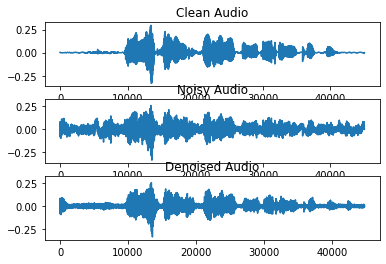

In [28]:
# plot
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

ax1.plot(cleanAudio)
ax1.set_title("Clean Audio")

ax2.plot(noisyAudio)
ax2.set_title("Noisy Audio")

ax3.plot(denoisedAudioFullyConvolutional)
ax3.set_title("Denoised Audio")


In [29]:
import IPython.display as ipd
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

In [30]:
ipd.Audio(data=cleanAudio, rate=fs) # load a local WAV file

In [31]:
ipd.Audio(data=noisyAudio, rate=fs) # load a local WAV file